# Community Solar Hardware Recommender

## Overview
Returns hardware recommendations based on various different goals

### Current Gaps
* filter hardware list, but by what? top 50%? Which is the most important characteristic?
* hardware inneficiencies
* confirm that the NREL model is based off of the weather file and that encompasses overcast chance
* change in cost of electricity from grid (and inflation) over time (see NREL levelized cost calculator
* include participation rate
* check other TEA papers that use NREL and replicate their methods
* more granular modeling - go by month and consider 2 hour options

## Psuedo Code

Inputs:
* Location
* Range of PV and Battery options
* Cost estimates
* Network info
* shading on an hourly basis

1) Get hourly irradiance from NREL
2) loop through every possible PV and battery combo and determine:
    * estimated hardware costs
    * estimated annual PV Wh generation (does it get curtailed if it exceeds battery capacity)?
    * maximum automated DR participation (combines battery capacity and SOA during event windows)
    * calculates ROI
3) Remove options that don't break even within 7 years from data set
4) graph all data
5) identify:
    * hardware combination with quickest ROI
    * largest PV system within 8 year ROI
    * largest Battery system within 7 year ROI
    * largest overall system within 7 year ROI
    * system with largest avoided grid consumption
    * system with largest automated DR event participation
    
## Variations to Test

* only best hardware 
    * w to wh
    * $ per wh
* only worst hardware
* afternoon call times

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import requests
import math
from scipy import stats 
from sklearn import linear_model

In [2]:
#GLOBALS - to be changed for each run - probably should implement them as loops
#azimuth
#azGlobal = 250
#network
netNumGlobal = 3

#Max Hardware Sizes
#500 is an estimate for the largest array someone can relatively easily install without a professional
pvMaxW = 500
#2kWh is the largest system FDNY allows without additional beurocracy 
batMaxWh = 2000

#14% losses
shading = .86

#totDerating = equipDerating * shading

## Commercially Available Power Station Data

Here we're interested in understanding modeling what would be representative of commercially available hardware today.

Specifically, we want to identify which characteristics best impact retail price. Because the variables in retail price are vague (i.e. sales, loss-leaders, marketing, etc.), we want to avoid over fitting, so a simple regression or median $/Wh is probably best. The regression is focused more on the relationships between data, so it might better reflect 

Similarly, max PV watts is not purely determined by battery Wh because of design and marketing choices that are not just based on maximum technical ability. (For example, a product line might use the same CC circuitry so the max PV W size is perhaps correlated to the smallest battery Wh within that group of products)

All product data comes from the company's website or product manual, except for inverter efficiency which mostly comes from conversations with customer service representatives.

For other characteristics median is best.

In [3]:
# read in hardware data to dataframe
#hardware_df = pd.read_csv('data/DER_Hardware_November_LiFePo4_batteriespowerstations_updated_NOV19.csv')

hardware_df = pd.read_csv('data/DER_Hardware_November_LiFePo4_batteriespowerstations_updated_NOV22.csv')

#clean data - these columns aren't used in this analysis
hardware_df = hardware_df.drop(columns=['Link','Battery Type','App Control','Bypass Mode','Min PV Voltage'
                                        ,'Inverter Watts', 'Warranty Years','Lifespan'])

priceDate = '(11/20/2023)'

print(hardware_df.shape)
hardware_df.head()

(50, 16)


,Make,Model,Battery Wh,Max PV Watts,W to Wh Ratio,Max PV Voltage,Max PV Amps,Max AC Input Amps,Max AC Input Watts,Inverter Efficiency,Retail Price (11/12/2023),Price per Wh (11/12/2023),Full Price (11/20/2023),Price per Wh (11/20/2023),Cycles,DoD
0,Jackery,Explorer 300 Plus,288.00,100,0.347222,27.0,5.0,5.0,100.0,85.0,254.0,0.88,299.99,1.04,3000,80.0
1,Jackery,Explorer 700 Plus,680.96,600,0.881109,60.0,11.0,15.0,1800.0,85.0,399.0,0.59,799.00,1.17,4000,70.0
2,Jackery,Explorer 1000 Plus,1264.64,800,0.632591,60.0,22.0,15.0,1800.0,85.0,899.0,0.71,1199.00,0.95,4000,70.0
3,Jackery,Explorer 2000 Plus,2042.80,1400,0.685334,60.0,24.0,15.0,1800.0,85.0,1659.0,0.81,2199.00,1.08,4000,70.0
4,Pecron,E600LFP,614.00,400,0.651466,18.0,7.0,NaN,NaN,85.0,299.0,0.49,499.00,0.81,3500,80.0


In [4]:
# data snapshot
print('Total Number of Companies: ' + str(hardware_df.drop_duplicates(subset=['Make']).shape[0]))
print('Total Number of Products: ' + str(hardware_df.shape[0]))

#hardware_df.plot(kind = 'scatter', x = 'W to Wh ratio', y = 'Price per Wh', c='red',colormap='viridis')
print('')
print('*** Wh ***')
print('Min:' + str(min(hardware_df['Battery Wh'])))
print('Max:' + str(max(hardware_df['Battery Wh'])))
print('Median:' + str(hardware_df['Battery Wh'].median()))

print('')
print('*** W ***')
print('Min:' + str(min(hardware_df['Max PV Watts'])))
print('Max:' + str(max(hardware_df['Max PV Watts'])))
print('Median:' + str(hardware_df['Max PV Watts'].median()))

print('')
print('*** W/Wh ***')
print('Min:' + str(min(hardware_df['W to Wh Ratio'])))
print('Max:' + str(max(hardware_df['W to Wh Ratio'])))
print('Median:' + str(hardware_df['W to Wh Ratio'].median()))

print('')
print('*** Wh/$ ' + priceDate + '***')
print('Min:' + str(min(hardware_df['Price per Wh ' + priceDate])))
print('Max:' + str(max(hardware_df['Price per Wh ' + priceDate])))
print('Median:' + str(hardware_df['Price per Wh ' + priceDate].median()))

print('')
print('*** Cycles ***')
print('Min:' + str(min(hardware_df['Cycles'])))
print('Max:' + str(max(hardware_df['Cycles'])))
print('Median:' + str(hardware_df['Cycles'].median()))

print('')
print('*** Inv Eff ***')
print('Min:' + str(min(hardware_df['Inverter Efficiency'])))
print('Max:' + str(max(hardware_df['Inverter Efficiency'])))
print('Median:' + str(hardware_df['Inverter Efficiency'].median()))

Total Number of Companies: 16
Total Number of Products: 50

*** Wh ***
Min:99.9
Max:2232.0
Median:1088.0

*** W ***
Min:40
Max:2100
Median:400.0

*** W/Wh ***
Min:0.1015625
Max:1.025390625
Median:0.39861289860000004

*** Wh/$ (11/20/2023)***
Min:0.52
Max:1.73
Median:0.935

*** Cycles ***
Min:2000
Max:6000
Median:3100.0

*** Inv Eff ***
Min:85.0
Max:92.0
Median:90.0


In [5]:
#Pearson Correlation Matrix

hardware_df.corr()

# Note:
# that correlations between characteristics that have the same variables or a direct relationship
# (like PV watts to W/Wh Ratio) should be ignored.


,Battery Wh,Max PV Watts,W to Wh Ratio,Max PV Voltage,Max PV Amps,Max AC Input Amps,Max AC Input Watts,Inverter Efficiency,Retail Price (11/12/2023),Price per Wh (11/12/2023),Full Price (11/20/2023),Price per Wh (11/20/2023),Cycles,DoD
Battery Wh,1.000000,0.764444,0.133108,0.520663,0.517852,0.634885,0.733871,-0.029729,0.778020,-0.274338,0.847022,-0.378856,0.362006,-0.103878
Max PV Watts,0.764444,1.000000,0.675336,0.610729,0.437912,0.635489,0.835167,-0.333910,0.526259,-0.260108,0.655671,-0.224128,0.294999,-0.294878
W to Wh Ratio,0.133108,0.675336,1.000000,0.415945,0.175507,0.408062,0.549400,-0.513621,0.014778,-0.106871,0.155616,0.128094,0.119893,-0.427138
Max PV Voltage,0.520663,0.610729,0.415945,1.000000,0.406000,0.888635,0.881071,0.261511,0.384276,-0.163680,0.368410,-0.240730,0.144689,-0.116261
Max PV Amps,0.517852,0.437912,0.175507,0.406000,1.000000,0.709162,0.669885,0.094289,0.567865,0.033722,0.542654,-0.140737,0.557913,-0.460062
Max AC Input Amps,0.634885,0.635489,0.408062,0.888635,0.709162,1.000000,0.769122,0.250000,0.503869,-0.593224,0.608754,-0.230283,0.560112,-0.447214
Max AC Input Watts,0.733871,0.835167,0.549400,0.881071,0.669885,0.769122,1.000000,-0.291872,0.696746,-0.398583,0.786288,-0.214206,0.698011,-0.646322
Inverter Efficiency,-0.029729,-0.333910,-0.513621,0.261511,0.094289,0.250000,-0.291872,1.000000,0.131062,0.177855,-0.058687,-0.061221,-0.290390,0.540364
Retail Price (11/12/2023),0.778020,0.526259,0.014778,0.384276,0.567865,0.503869,0.696746,0.131062,1.000000,0.296074,0.942925,0.110170,0.246366,-0.061187
Price per Wh (11/12/2023),-0.274338,-0.260108,-0.106871,-0.163680,0.033722,-0.593224,-0.398583,0.177855,0.296074,1.000000,0.121206,0.848122,-0.218596,0.109003


In [6]:
#which variables have the strongest correlation to price?

print('Notable Correlations with Raw Data:')

print("Bat Wh to Retail Price (11/12/2023): " + str(hardware_df['Battery Wh'].corr(hardware_df['Retail Price (11/12/2023)'])))

print("Bat Wh to Retail Price " + priceDate +": " + str(hardware_df['Battery Wh'].corr(hardware_df['Full Price (11/20/2023)'])))

print("Max PV Watts to Retail Price " + priceDate +": " + str(hardware_df['Max PV Watts'].corr(hardware_df['Full Price (11/20/2023)'])))

print("Bat Wh to Max PV Watts: " + str(hardware_df['Battery Wh'].corr(hardware_df['Max PV Watts'])))

#this high correlation is likely due to the fact that the battery charging circuitry is the same for both sources
#neither is likely directly dependent on the other
print("AC Input Watts to Max PV Watts: " + str(hardware_df['Max AC Input Watts'].corr(hardware_df['Max PV Watts'])))

print("AC Input Watts to Price (11/20/2023): " + str(hardware_df['Max AC Input Watts'].corr(hardware_df['Full Price (11/20/2023)'])))


Notable Correlations with Raw Data:
Bat Wh to Retail Price (11/12/2023): 0.7780201218843964
Bat Wh to Retail Price (11/20/2023): 0.8470224181867106
Max PV Watts to Retail Price (11/20/2023): 0.6556706700752509
Bat Wh to Max PV Watts: 0.7644443268002278
AC Input Watts to Max PV Watts: 0.8351671680641936
AC Input Watts to Price (11/20/2023): 0.7862875749048639


### Power Station Price

Goal: Determine best predictor of price between Median $ per Wh vs Linear Regression

Note that  retail price has many unknown variables, which can include seasonal price fluctuations, sales, marketing strategies, supply chain issues, etc. which lead to a significant amount of uncertainty.

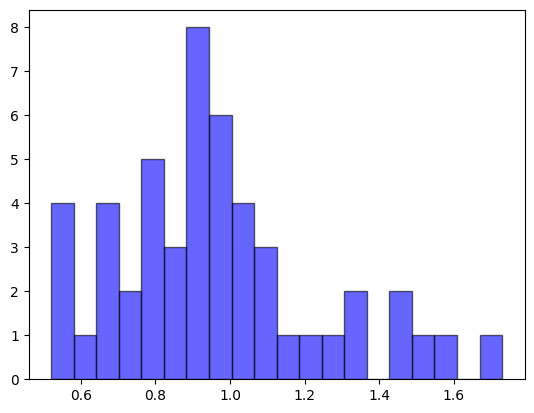

In [7]:
#price per Wh is not normally distributed
plt.hist(hardware_df['Price per Wh ' + priceDate], bins=20, alpha=0.6, color='b', edgecolor='black') 
  
plt.show()

0.7532253559614321
169.56113541895309
0.8470224181867104
8.999182126311219e-15
0.06822748879660089


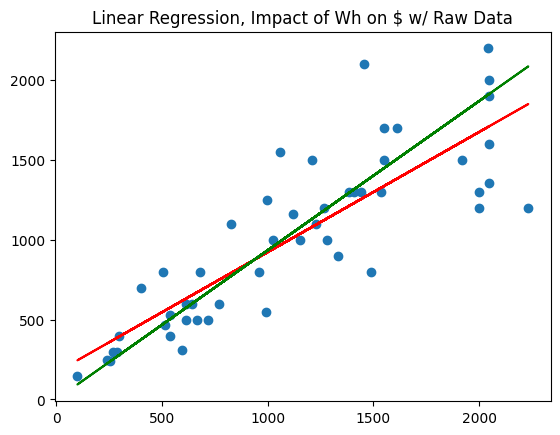

In [8]:
pSlope, pIntercept, pR, pP, pStd_err = stats.linregress(hardware_df['Battery Wh'],hardware_df['Full Price (11/20/2023)'])
print(pSlope)
print(pIntercept)
print(pR)
print(pP)
print(pStd_err)


def powerStationPrice(x):
  return pSlope * x + pIntercept 

priceModel = list(map(powerStationPrice, hardware_df['Battery Wh']))

#retail prices (11/12/2023)
#plt.scatter(hardware_df['Battery Wh'],hardware_df['Retail Price (11/12/2023)'], color='y',s=70)

#full prices (11/20/2023)
plt.scatter(hardware_df['Battery Wh'],hardware_df['Full Price (11/20/2023)'])

#red is the regression line
plt.plot(hardware_df['Battery Wh'], priceModel, color='r')

#green is median price per Wh
plt.plot(hardware_df['Battery Wh'],hardware_df['Battery Wh'] * hardware_df['Price per Wh (11/20/2023)'].median(), color='g')

plt.title("Linear Regression, Impact of Wh on $ w/ Raw Data", fontdict=None, loc='center', pad=None)
plt.show()



In [9]:
print('Price Method Comparision w/ 100Wh:')
print('Regression: ' + str(powerStationPrice(100)))
print('Median: ' + str(hardware_df['Price per Wh (11/20/2023)'].median()*100))

Price Method Comparision w/ 100Wh:
Regression: 244.8836710150963
Median: 93.5


### Multi Regression Exploration

In [10]:
# # NOT USED

# #independent variables
# inX = hardware_df[['Battery Wh', 'Max PV Watts','Max AC Input Watts']].values

# #dependent variables
# outY = hardware_df['Full Price (11/20/2023)'].values

# regr = linear_model.LinearRegression()
# model = regr.fit(inX, outY) 

# response = model.predict(inX)
# predicted = regr.predict([[268,200]])

# print(predicted)

# r2 = model.score(inX, outY)
# r2

### Max PV Watts

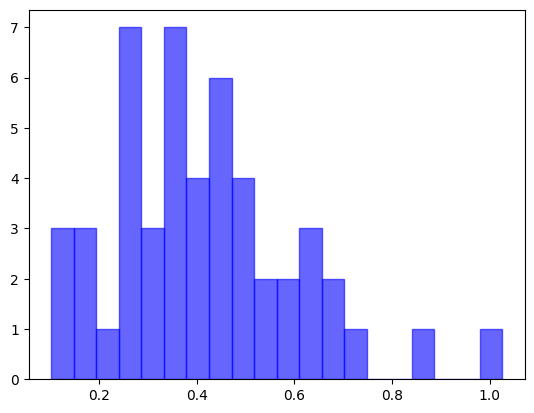

In [11]:
#W to Wh is somewhat normally distributed
plt.hist(hardware_df['W to Wh Ratio'], bins=20, alpha=0.6, color='b', edgecolor='b') 
  
plt.show()

0.5101941913925241
-93.69208545138463
0.7644443268002279
1.0436814090217874e-10
0.06210403146835798


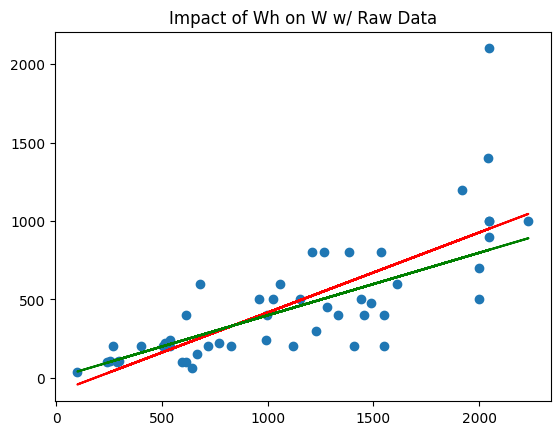

-42.67266631213222

In [12]:
wSlope, wIntercept, wR, wP, wStd_err = stats.linregress(hardware_df['Battery Wh'],hardware_df['Max PV Watts'])
print(wSlope)
print(wIntercept)
print(wR)
print(wP)
print(wStd_err)


#input battery Wh -> outputs max PV Watts
def maxPVWatts(x):
  return wSlope * x + wIntercept 

maxPVWattsModel = list(map(maxPVWatts, hardware_df['Battery Wh']))
plt.scatter(hardware_df['Battery Wh'],hardware_df['Max PV Watts'])


#red is regression slope
plt.plot(hardware_df['Battery Wh'], maxPVWattsModel,color='r')

#green is median ratio
plt.plot(hardware_df['Battery Wh'], hardware_df['Battery Wh'] * hardware_df['W to Wh Ratio'].median(),color='g')

plt.title("Impact of Wh on W w/ Raw Data", fontdict=None, loc='center', pad=None)


plt.show()

maxPVWatts(100)


In [13]:
# filter hardware list to remove outliers

#remove rows with W to Wh ratios > 1
fhardware_df = hardware_df[(hardware_df['W to Wh Ratio'] < 1.0)]
fhardware_df = fhardware_df[(fhardware_df['W to Wh Ratio'] > .1)]

# data snapshot
print('Total Number of Companies: ' + str(fhardware_df.drop_duplicates(subset=['Make']).shape[0]))
print('Total Number of Products: ' + str(fhardware_df.shape[0]))

fhardware_df.head()

Total Number of Companies: 16
Total Number of Products: 49


,Make,Model,Battery Wh,Max PV Watts,W to Wh Ratio,Max PV Voltage,Max PV Amps,Max AC Input Amps,Max AC Input Watts,Inverter Efficiency,Retail Price (11/12/2023),Price per Wh (11/12/2023),Full Price (11/20/2023),Price per Wh (11/20/2023),Cycles,DoD
0,Jackery,Explorer 300 Plus,288.00,100,0.347222,27.0,5.0,5.0,100.0,85.0,254.0,0.88,299.99,1.04,3000,80.0
1,Jackery,Explorer 700 Plus,680.96,600,0.881109,60.0,11.0,15.0,1800.0,85.0,399.0,0.59,799.00,1.17,4000,70.0
2,Jackery,Explorer 1000 Plus,1264.64,800,0.632591,60.0,22.0,15.0,1800.0,85.0,899.0,0.71,1199.00,0.95,4000,70.0
3,Jackery,Explorer 2000 Plus,2042.80,1400,0.685334,60.0,24.0,15.0,1800.0,85.0,1659.0,0.81,2199.00,1.08,4000,70.0
4,Pecron,E600LFP,614.00,400,0.651466,18.0,7.0,NaN,NaN,85.0,299.0,0.49,499.00,0.81,3500,80.0


0.4442083456456448
-45.17244021364672
0.801344648627246
4.643352191850361e-12
0.048368986197932555


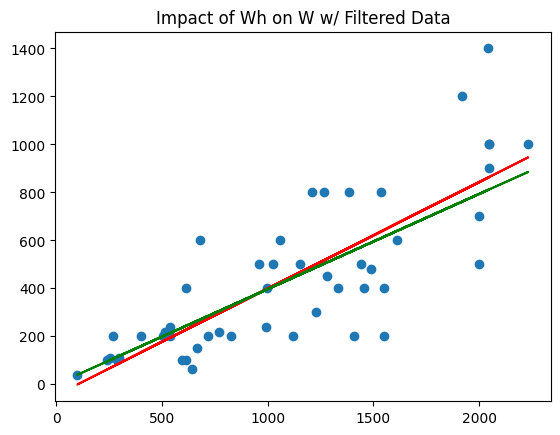

-42.67266631213222

In [14]:
wSlopeF, wInterceptF, wRF, wPF, wStd_errF = stats.linregress(fhardware_df['Battery Wh'],fhardware_df['Max PV Watts'])
print(wSlopeF)
print(wInterceptF)
print(wRF)
print(wPF)
print(wStd_errF)


#input battery Wh -> outputs max PV Watts
def maxPVWattsF(x):
  return wSlopeF * x + wInterceptF 

maxPVWattsModelF = list(map(maxPVWattsF, fhardware_df['Battery Wh']))
plt.scatter(fhardware_df['Battery Wh'],fhardware_df['Max PV Watts'])


#red is regression slope
plt.plot(fhardware_df['Battery Wh'], maxPVWattsModelF,color='r')

#green is median ratio
plt.plot(fhardware_df['Battery Wh'], fhardware_df['Battery Wh'] * fhardware_df['W to Wh Ratio'].median(),color='g')

plt.title("Impact of Wh on W w/ Filtered Data", fontdict=None, loc='center', pad=None)

plt.show()

maxPVWatts(100)


In [15]:
#filter out product lines that duplicate specs
filterModels = ['EB55','EB70S','AC60', 'AC60P','AC180P','Jump 1000','Jump 1800','P2001']

fhardware_df = fhardware_df[~fhardware_df.Model.isin(filterModels)]
fhardware_df.shape
#hardware_productline_df.tail()

(41, 16)

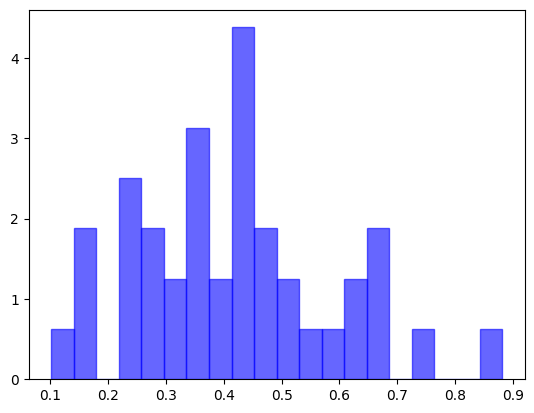

In [16]:
#W to Wh is somewhat normally distributed
plt.hist(fhardware_df['W to Wh Ratio'], bins=20, density=True, alpha=0.6, color='b', edgecolor='b') 
  
plt.show()

0.4935180983027551
-68.9272432295374
0.8535465306647007
1.3358050141426673e-12
0.048238651342935514


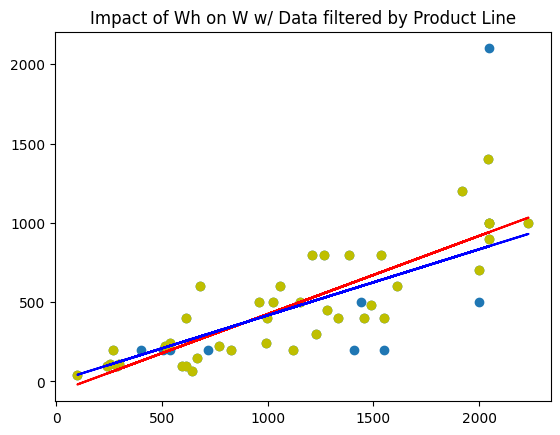

-42.67266631213222

In [17]:

wSlopeFF, wInterceptFF, wRFF, wPFF, wStd_errFF = stats.linregress(fhardware_df['Battery Wh'],fhardware_df ['Max PV Watts'])

print(wSlopeFF)
print(wInterceptFF)
print(wRFF)
print(wPFF)
print(wStd_errFF)


#input battery Wh -> outputs max PV Watts
def maxPVWattsFF(x):
  return wSlopeFF * x + wInterceptFF


maxPVWattsModelFF = list(map(maxPVWattsFF, fhardware_df['Battery Wh']))

#all products in archive
plt.scatter(hardware_df['Battery Wh'],hardware_df['Max PV Watts'])

#products filtered by product line
plt.scatter(fhardware_df['Battery Wh'],fhardware_df['Max PV Watts'], color='y')

#linear regression on products filtered by product line (this is best)
plt.plot(fhardware_df['Battery Wh'], maxPVWattsModelFF,color='r')

#linear regression w/ all data
#plt.plot(hardware_df['Battery Wh'], maxPVWattsModel,color='pink')

#median w to wh ratio
mHf = fhardware_df['W to Wh Ratio'].median()
plt.plot(fhardware_df['Battery Wh'], fhardware_df['Battery Wh'] * mHf,color='b')

#yellow is median ratio for raw data
#plt.plot(hardware_df['Battery Wh'], hardware_df['Battery Wh'] * hardware_df['W to Wh Ratio'].median(),color='y')


plt.title("Impact of Wh on W w/ Data filtered by Product Line", fontdict=None, loc='center', pad=None)

plt.show()

maxPVWatts(100)


### TEA Results - Representative Power Station Specs

#### Independent Characteristics

In [18]:

#80% depth of discharge for LiFePO4 batteries
LiFePOdod = hardware_df['DoD'].median()*.01
print("Median LiFePO4 DoD: " + str(LiFePOdod))

medBatCycles = round(hardware_df['Cycles'].median())
eol = medBatCycles / 365

print('Median battery cycles: ' + str(medBatCycles) + " (" + str(round(eol/.01)*.01) + " years)")

# check against list of hardware
# note: inv_eff' must be between 90 and 99.5 for PV Watts API
inverterEfficiency = hardware_df['Inverter Efficiency'].median() * .01
print('Median inverter efficiency: ' + str(inverterEfficiency))

#equipment derating -> charge controller efficiency
equipDerating = .99

Median LiFePO4 DoD: 0.8
Median battery cycles: 3100 (8.49 years)
Median inverter efficiency: 0.9


#### Dependent Characteristics

In [19]:
#for pricing correlation coeficients and linear regression is used because it provides a clearer picture of the impact of characteristics on price (rather than simply median $ per Wh)

#median is used to characteristics that include outliers and dont have a strong correllation to other characteristics
# this includes DoD and Cycles


# check against list of hardware
# not currently used in model
#gridChargingEfficiency = .96

#battery W to Wh ratio
#should this be a regression too???
#batPVcapacity = fhardware_df['W to Wh ratio'].median()
#print('W to Wh median (filtered): ' + str(batPVcapacity))
print('Max PV Watts FF function: ' + str(wSlopeFF) + ' * Wh + ' + str(wInterceptFF))


#batteryDollarPerWh = math.floor(fhardware_df['Price per Wh'].median()*100)*.01
#print('$ per Wh median: ' + str(batteryDollarPerWh) + " dollars for 1 Wh")
print('Power Station Price function: ' + str(pSlope) + ' * Wh + ' + str(pIntercept))

# print(str(100*batteryDollarPerWh))
# powerStationPrice(100)

Max PV Watts FF function: 0.4935180983027551 * Wh + -68.9272432295374
Power Station Price function: 0.7532253559614321 * Wh + 169.56113541895309


## Con Ed Network Data

In [20]:
myNetworks = ['city hall','long island city','crown heights','randalls island', 'millwood west', 'grasslands','fresh kills','central bronx','northeast bronx']

# read in hardware data to dataframe
networks_df = pd.read_csv('data/conEdNetworks2023-cleaned.csv')

networks_df.head()

,borough,network,start time,end time,tier
0,bronx,central bronx,14:00,18:00,2
1,bronx,fordham,16:00,20:00,2
2,bronx,northeast bronx,16:00,20:00,2
3,bronx,riverdale,16:00,20:00,1
4,bronx,southeast bronx,16:00,20:00,2


In [21]:
#returns the network info for a given network
def getNetworkInfo(networkName):
    return networks_df.loc[networks_df['network']== networkName]

#returns the tier for a given item in the network info list
def getTierRate(nNum):
    tier = networkInfo[nNum]['tier'].iloc[0]
    #tier 2 networks pay at a higher rate
    if tier == 1:
        return 18
    else:
        return 25
    
#returns the borough for a given item in the network info list
def getBoroughRate(nNum):
    #westchester and staten island pay at a lower rate
    if borough not in ['westchester','staten island']:
        return 18
    else:
        return 6

#returns borough name
def getBorough(nNum):
    return networkInfo[nNum]['borough'].iloc[0]

#returns event start time
def getStartTime(nNum):
    return int(networkInfo[nNum]['start time'].iloc[0].split(":")[0])

In [22]:
#retrieve network info
print(myNetworks)

networkInfo = []

networkNum = netNumGlobal


for i in myNetworks:
    networkInfo.append(getNetworkInfo(i))
    #print(networks_df.loc[networks_df['network']== i])
    
#tier = networkInfo[networkNum]['tier'].iloc[0]
borough = getBorough(networkNum)

startTime =getStartTime(networkNum)

['city hall', 'long island city', 'crown heights', 'randalls island', 'millwood west', 'grasslands', 'fresh kills', 'central bronx', 'northeast bronx']


In [23]:
# Super loop
# for i in myNetworks:    
#     getNetworkInfo(i)

In [24]:
#DR variables


# #tier 2 networks pay at a higher rate
# if tier == 1:
#     DLRPratePerkW = 18
# else:
#     DLRPratePerkW = 25

DLRPratePerkW = getTierRate(networkNum)
print("DLRP rate: " + str(DLRPratePerkW))

# #westchester and staten island pay at a lower rate
# if borough not in ['westchester','staten island']:
#     CSRPratePerkW = 18
# else:
#     CSRPratePerkW = 6
CSRPratePerkW = getBoroughRate(networkNum)

print("CSRP rate: " + str(CSRPratePerkW))

#performance rates aren't currently used in this model
CSRPperfRatePerkW = 1
DLRPperfRatePerkW = 1

#this is the monthly reservation payment
totDRratePerkW = CSRPratePerkW + DLRPratePerkW

DLRP rate: 18
CSRP rate: 18


## Solar Access

To do:
* Shading
* capacity factor? 14% NOT NECESSARILY BECAUSE THE NREL DATA IS ALREADY BASED ON WEATHER!

In [25]:
#PV Installation Details
lat = 40.7128
long = 74.0060

#seasonal tilt options: summer, winter, average
season = 'summer'

#azimuth = azGlobal

In [26]:
 #api documentation: https://developer.nrel.gov/docs/solar/pvwatts/v8/#response-fields
    
def pvWattsRequest(lat, season, az):
        
    if season == 'summer':
        s = -15
    elif season == 'winter':
        s = 15
    else:
        s = 0
        
    #shading = 0
        
    # api documentation: https://developer.nrel.gov/docs/solar/pvwatts/v8/#request-url
    nAzimuth = str(az) #cardinal direction
    nCapkW = str(.05) #nameplate capacity minimum 0.05*
    nLat = str(lat) #latitude
    nTilt = str(lat + s)
    nLosses = str(shading * equipDerating) #derating*
    nInvEff = str(max(inverterEfficiency,0.9) * 100) #inverter efficiency - cannot be under 90% for API*
    nBorough = borough
    nTimeframe = 'hourly'
    nrelKey = 'oAhJWNZJSMfoZqx83MMOV1pYheWkAi2Z2XVn59UT'
    getURL = 'https://developer.nrel.gov/api/pvwatts/v8.json?api_key=' + nrelKey + '&azimuth=' + nAzimuth+'&system_capacity=' + nCapkW +'&losses=' + nLosses +'&array_type=1&module_type=0&inv_eff=' + nInvEff + '&tilt=' +  nTilt +'&address=' + nBorough +',ny&timeframe=' + nTimeframe

    #print(getURL)
    return getURL

#we care about hourly plane of array irradiance (POA)
# we can also get hourly DC output, but we'll quickly exceed the 1000 calls an hour max...
# *doesn't impact POA

#change 90 back to azimuth, maybe
nrelData = requests.get(pvWattsRequest(lat, season,90)).json()['outputs']
print(nrelData)

nrelDataEast = requests.get(pvWattsRequest(lat, season,110)).json()['outputs']

nrelDataWest = requests.get(pvWattsRequest(lat, season,250)).json()['outputs']


{'ac_monthly': [2.735563819898277, 3.556123847160979, 5.011997972307982, 6.0209076898725, 6.910240949197672, 7.187765017269328, 7.296275878663686, 6.390991443975598, 5.398615598808762, 3.9180186772541, 2.584783544900682, 2.135213280527586], 'poa_monthly': [60.14740216453402, 77.91646109242645, 112.3521334905187, 138.4040626341294, 163.9140123030251, 174.9888089209022, 180.5281770349506, 158.3925009086587, 129.4726475686803, 90.2562465458483, 58.28153310494777, 47.39570146169559], 'solrad_monthly': [1.940238779501098, 2.782730753300945, 3.624262370661893, 4.613468754470978, 5.287548783968551, 5.832960297363408, 5.823489581772599, 5.10943551318254, 4.315754918956008, 2.911491824059623, 1.942717770164926, 1.528893595538567], 'dc_monthly': [3.0629085430058, 3.971777944322026, 5.593793147830179, 6.71613080058477, 7.713194044034589, 8.011859352952579, 8.133703526887885, 7.128461195073601, 6.022086540448248, 4.378233985555651, 2.894555477980537, 2.394994278704396], 'ac_annual': 59.14649771983

In [27]:
print('Annual AC PV Production w/ 50W module')

inef = .99 * .9

print('POA Monthly: ' + str((sum(nrelData['poa_monthly'])/12) *.05 * 365 * inef))

print('DC Monthly: ' + str(sum(nrelData['dc_monthly'])* inef))

print('AC Monthly: ' + str(sum(nrelData['ac_monthly'])))

print('AC Annual: ' + str(nrelData['ac_annual']))

print('Solar Radiation Annual: ' + str(nrelData['solrad_annual']*365*.05 * inef))

print('POA Hourly: ' + str(sum(nrelData['poa'])*.001 * 0.05 * inef))

print('')
print('Estimated annual AC production with 50W module (they are all different):')

#multiply this by PV module size
# DC output = annual daily sun hour average * 365 days * cc efficiency * shade losses * module W
# AC output = DC output * inverter efficiency
print('ac_annual kW NREL: ' + str(nrelData['ac_annual']))

dailyAvgRad = nrelData['solrad_annual']
dailyAvgRadEast = nrelDataEast['solrad_annual']
dailyAvgRadWest = nrelDataWest['solrad_annual']

#this is what we use when we calculate all our options...
dcOutputFactors = dailyAvgRad * 365 * shading
dcOutputFactorsEast = dailyAvgRadEast * 365 * shading
dcOutputFactorsWest = dailyAvgRadWest * 365 * shading

#convert to kW
print('ac annual kW calculated from annual average radiation: ' + str(dcOutputFactors * .050 *  inef))

#yet another way to calculate annaul AC output (USE THIS)
print('ac annual kW calculated from predicted monthly DC output:' + str(sum(nrelData['dc_monthly'])*inef))

hourlyPOA = nrelData['poa']
hourlyDC = nrelData['dc']
hourlyDCEast = nrelDataEast['dc']
hourlyDCWest = nrelDataWest['dc']

#print(hourlyPOA)

Annual AC PV Production w/ 50W module
POA Monthly: 1886.3143293025316
DC Monthly: 58.82533366410582
AC Monthly: 59.14649771983716
AC Annual: 59.14649771983711
Solar Radiation Annual: 61.94396249974418
POA Hourly: 62.01581413499998

Estimated annual AC production with 50W module (they are all different):
ac_annual kW NREL: 59.14649771983711
ac annual kW calculated from annual average radiation: 53.271807749779995
ac annual kW calculated from predicted monthly DC output:58.82533366410582


## Grid Electricity Costs

Needed:
how to factor in annual increases?

In [28]:
# GRID ELECTRICITY COSTS
#Annual Rolling Average is probably best to use here

# source: EIA Electric Power Month, November 2023
# https://www.eia.gov/electricity/monthly/current_month/november2023.pdf
#Average Price of Electricity to Ultimate Customers - Residential - NYS - Year to Date
#septAvgYTDCents = 22.16

#source: https://www.nyserda.ny.gov/Energy-Prices/Electricity/Monthly-Avg-Electricity-Residential
#2023 - January to Sept
monthlyResElecPricesCents = [23.57, 23.60,21.18,19.81,20.47,21.63,22.27,22.33,23.23]
#2022 Oct to Dec
monthlyResElecPricesCents22 = [23.3,23.7,22.8]

monthlyResElecPricesCents.extend(monthlyResElecPricesCents22)
#print(monthlyResElecPrices)

rollingAvgDollars =round((sum(monthlyResElecPricesCents)/len(monthlyResElecPricesCents))* .01,4) 
print('NYS Residential Electricity Rolling Average - September 2023: $' + str(rollingAvgDollars) + '/kWh')

def avoidedUtilityCosts(generatedkWAC):
    
    annualAvoidedCosts = generatedkWAC * rollingAvgDollars
    
    return annualAvoidedCosts

NYS Residential Electricity Rolling Average - September 2023: $0.2232/kWh


## Hardware Costs

In [29]:
# HARDWARE COSTS

'''
I'm looking levelized cost - see NREL's report
'''
#variable costs
pvDollarPerW = 1.0 * .7
mountDollarPerW = .4
cablePerFt = .77 * 2 #pos & neg cables 
cableRunFt = 15

#fixed costs
insulation = 4.38
smartController = 100
operatingCosts = 0 #DR aggregation operator costs are not considered here. 
fixedHardwareCosts = smartController + operatingCosts + insulation

def hardwareCosts(pvW, batWh):
    #variable hardware costs
    # average cost of LiFePO4 batteries currently on market
    # average cost of PV modules per kW
    
    variableCosts = powerStationPrice(batWh) + (pvW * (pvDollarPerW + mountDollarPerW)) + (cablePerFt * cableRunFt)

    c = fixedHardwareCosts + variableCosts
    return c

print(hardwareCosts(100, 500))

#this is for testing existing battery systems with this model
def hardwareCostsFixedBattery(pvW):
    #variable hardware costs
    # average cost of LiFePO4 batteries currently on market
    # average cost of PV modules per kW

    variableCosts = (pvW * (pvDollarPerW + mountDollarPerW))


    c = fixedHardwareCosts + variableCosts
    return c

print(hardwareCostsFixedBattery(100))


783.6538133996692
214.38


In [30]:
#Max automated battery + PV generation during event windows from May through September
#assumes battery is fully charged (from either PV or grid) at start of event
#returns average hourly commitment i.e. reservation amount in watts
def maxDRParticipation(batWh, pvW,az):
    batteryACOutput = batWh * LiFePOdod * inverterEfficiency * .25
    
    runningTot = 0

    #days in the months May - September
    #daysInMonth = [31,30,31,31,30]
    
    #returns average PV generated for all window hours
    #Get all the DR event window hours from May 1st (day #121) through September 30th (day # 273)
    for d in range(121, 274):
        drEventWindowPOA = 0
        drEventDCWh = 0
        for e in range(startTime,startTime + 4):
            #POA for 1 hour during the event window
            drHour = ((d-1)*24)+e
            #drEventWindowPOA = drEventWindowPOA + hourlyPOA[drHour]
            #this gets scaled because its based on a 50W module
            
            if az == 110:
                drEventDCWh = drEventDCWh + (hourlyDCEast[drHour] * (pvW/50))
            elif az == 180:
                drEventDCWh = drEventDCWh + (hourlyDC[drHour] * (pvW/50))
            elif az == 250:
                drEventDCWh = drEventDCWh + (hourlyDCWest[drHour] * (pvW/50))

        #this is average to an hourly basis NOT the total production during the event
        runningTot = runningTot + (drEventDCWh/4)
        
        '''
        print((drEventWindowPOA/1000)*pvW * totDerating)
        print(drEventDCWh)
        print('')
        '''
    
    numDays = 274-121
    avgEventPVWhAC = (runningTot/numDays) * inverterEfficiency
    #print(avgEventPVWhAC)
    return avgEventPVWhAC + batteryACOutput

maxDRParticipation(1000, 500,180) * .001 * 36 * 5

32.4

In [31]:
'''
maximum amount of DR participation based on sum of:
battery capacity (assumes battery is full at start of DR event)
PV generation during event
'''
'''
maxAutoParticipation= (batterykWh * .25) + (pvWatts * eventSunHours * derating)
maxAutoDRGross = maxAutoParticipation * (CSRPratePerkW + DLRPratePerkW)

maxAvoidedEnergyConsumption = annualPVWatts

'''


#pass in inverter efficiency
#def genProductData(eff):
data = {
    'pvW':[],
    'batWh':[],
    'az':[],
    'hardwareDollars':[],
    'annualPVkWh':[],
    'annualPVkWhAC':[],
    #'avoidedCostsDollars':[],
    'maxAutoParticipation':[],
    'minParticipants':[],
    'annualIncome':[],
    'roi':[],
    'avoidedGridCosts':[],
    'drInc':[],
    'drIncAnn':[]
}
    

#battery watt hour loop 50 - 2000 incrementing by 50
for b in range(1,int(batMaxWh / 50)+1):
    bWh = b * 50
    
    maxPV = min(maxPVWattsFF(bWh), pvMaxW)
    #pv watts loop 50-500 incrementing by 10
    for p in range(1,int(maxPV / 10)+1):
        
        #loop through different azimuths
        for a in [110,180,250]:
            pW = p * 10
            #print(p * 10)

            #PV Watts
            data['pvW'].append(pW)
            #Battert Watt Hours
            data['batWh'].append(bWh)
            #Hardware Costs in Dollars
            hC = hardwareCosts(pW,bWh)
            data['hardwareDollars'].append(hC)
            #Annual PV generation (dailyAvgRad * 365 * equipDerating * shading)
            data['az']=a
            ### adjust for AZIMUTH!
            if a == 110:
                dcOF = dcOutputFactorsEast
            elif a == 180:
                dcOF = dcOutputFactors
            else:
                dcOF = dcOutputFactorsWest

            pvDCkWh = dcOF * .001 * pW
            data['annualPVkWh'].append(pvDCkWh)
            #Annual PV generation converted to AC
            pvACkWh = pvDCkWh * inverterEfficiency
            data['annualPVkWhAC'].append(pvACkWh)
            #total annual avoided grid consumption i.e. AC solar generation
            avoidedCosts = avoidedUtilityCosts(pvACkWh)
            data['avoidedGridCosts'].append(avoidedCosts)
            # maximum possible automated hourly DR participation : (available battery/4) + average PV generation during event hour  

            ### adjust for AZIMUTH!                
            maxParW = maxDRParticipation(bWh,pW,a)
            data['maxAutoParticipation'].append(maxParW)
            # minimum participants in aggregation if using homogenous systems
            data['minParticipants'].append(math.ceil(50000 / maxParW))
            #monthly income from DR participation
            drInc = (maxParW* 0.001 * totDRratePerkW)
            data['drInc'].append(drInc)
            #annual income from DR participation
            data['drIncAnn'].append(drInc * 5)
            #annual income
            inc = avoidedCosts + (drInc * 5)
            data['annualIncome'].append(inc)
            data['roi'].append(hC/inc)

#load data into a DataFrame object:
df = pd.DataFrame(data)

print(str(df.shape[0])+ ' total hardware combinations generated')

print(df.head())
print('--------------------------------------------------------')
print(df.tail())

4101 total hardware combinations generated
   pvW  batWh   az  hardwareDollars  annualPVkWh  annualPVkWhAC  \
0   10    200  250       458.686207    12.831001      11.547901   
1   10    200  250       458.686207    11.957757      10.761981   
2   10    200  250       458.686207    12.642752      11.378477   
3   20    200  250       469.686207    25.662002      23.095801   
4   20    200  250       469.686207    23.915514      21.523963   

   maxAutoParticipation  minParticipants  annualIncome        roi  \
0                  36.0             1389      9.057491  50.641638   
1                  36.0             1389      8.882074  51.641789   
2                  36.0             1389      9.019676  50.853956   
3                  36.0             1389     11.634983  40.368448   
4                  36.0             1389     11.284148  41.623540   

   avoidedGridCosts  drInc  drIncAnn  
0          2.577491  1.296      6.48  
1          2.402074  1.296      6.48  
2          2.539676  1

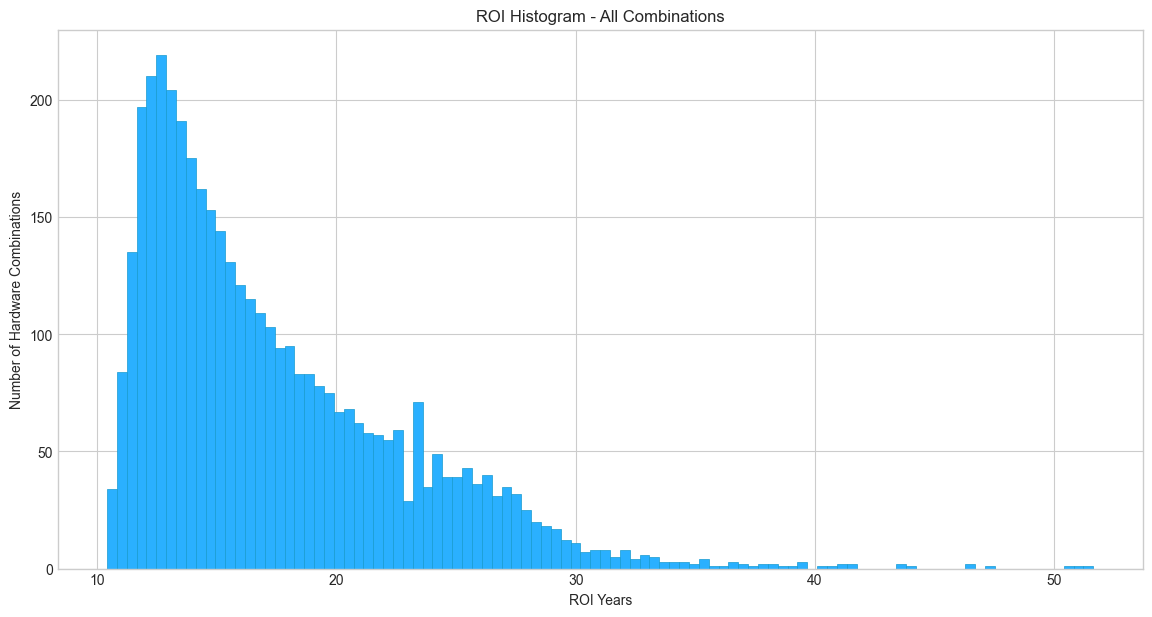

In [32]:
#ROI histogram

#n, bins, patches = plt.hist(df['roi'], 100, density=False, facecolor='g', alpha=0.75)

# Make it 14x7 inch
plt.figure(figsize=(14,7)) # Make it 14x7 inch
plt.style.use('seaborn-whitegrid') # nice and clean grid
plt.hist(df['roi'], bins=100, facecolor = '#2ab0ff', edgecolor='#169acf', linewidth=0.5)
plt.title('ROI Histogram - All Combinations') 
plt.xlabel('ROI Years') 
plt.ylabel('Number of Hardware Combinations') 
plt.show()

#style source: https://medium.com/@arseniytyurin/how-to-make-your-histogram-shine-69e432be39ca

0 hardware combinations with favorable ROI


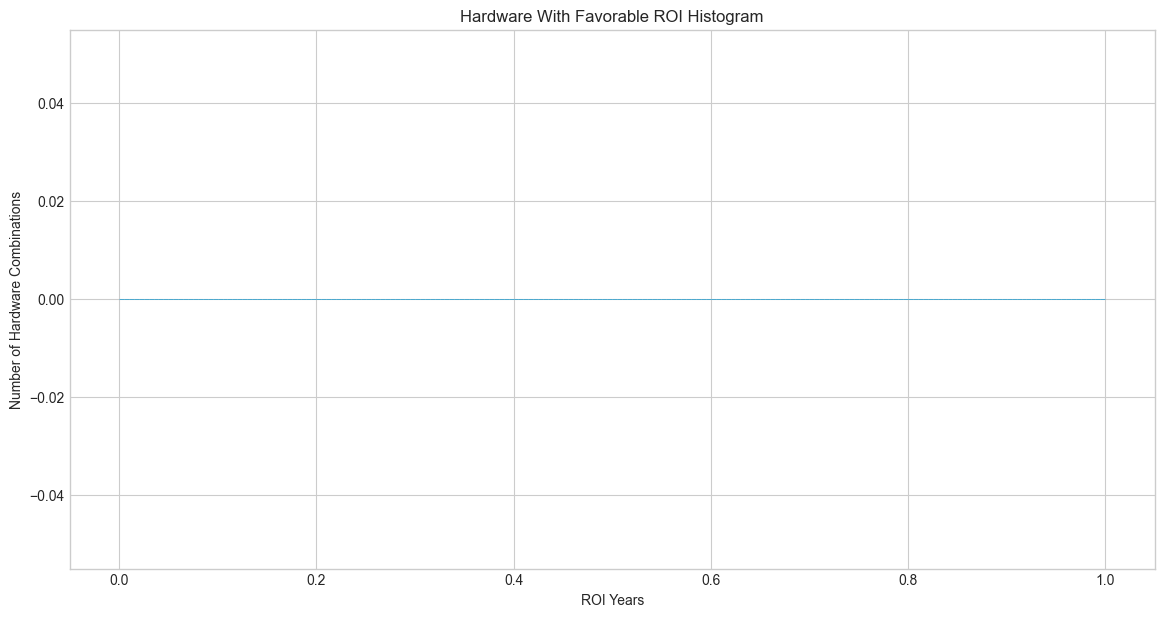

In [33]:
favROI_df = df[df['roi'] <= eol] 

print(str(favROI_df.shape[0])+ ' hardware combinations with favorable ROI')

# Make it 14x7 inch
plt.figure(figsize=(14,7)) # Make it 14x7 inch
plt.style.use('seaborn-whitegrid') # nice and clean grid
plt.hist(favROI_df['roi'], bins=200, facecolor = '#2ab0ff', edgecolor='#169acf', linewidth=0.5)
plt.title('Hardware With Favorable ROI Histogram') 
plt.xlabel('ROI Years') 
plt.ylabel('Number of Hardware Combinations') 
plt.show()

<AxesSubplot:title={'center':'Hardware w/ Favorable ROIs'}, xlabel='batWh', ylabel='pvW'>

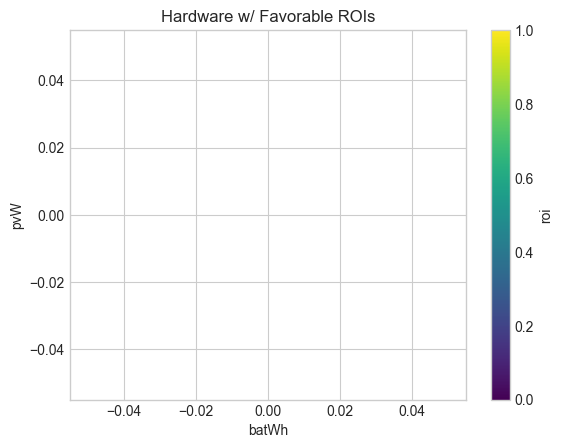

In [34]:
favROI_df.plot(kind = 'scatter', x = 'batWh', y = 'pvW', c='roi',colormap='viridis', title='Hardware w/ Favorable ROIs')

#df.show()

# df.savefig('foo.png')

# Results

### Most Favorable ROI

In [35]:
#most favorable ROI
favROI_df[favROI_df['roi'] == min(favROI_df['roi'])] 

ValueError: min() arg is an empty sequence

### PV System Range

In [ ]:
#smallest PV system
favROI_df[favROI_df['pvW'] == min(favROI_df['pvW'])] 

In [ ]:
#largest PV systems
largePV = favROI_df[favROI_df['pvW'] == max(favROI_df['pvW'])] 
largePV

###  Battery System Range

In [ ]:
#smallest Bat system
favROI_df[favROI_df['batWh'] == min(favROI_df['batWh'])] 

In [ ]:
#larget bat systems
favROI_df[favROI_df['batWh'] == max(favROI_df['batWh'])] 

### Largest System

In [ ]:
#largest overall system
largestSystem = largePV[largePV['batWh'] == max(largePV['batWh'])] 
largestSystem

### Upfront Costs

In [ ]:
#cheapest upfront cost
favROI_df[favROI_df['hardwareDollars'] == min(favROI_df['hardwareDollars'])] 

In [ ]:
#most expensive upfront cost
favROI_df[favROI_df['hardwareDollars'] == max(favROI_df['hardwareDollars'])] 

### DR Impact

In [ ]:
#best automated DR contribution
favROI_df[favROI_df['maxAutoParticipation'] == max(favROI_df['maxAutoParticipation'])] 

In [ ]:
#worst DR contribution
favROI_df[favROI_df['maxAutoParticipation'] == min(favROI_df['maxAutoParticipation'])] 


In [ ]:
#ratio of DR income to avoided electricity costs
incRatio = favROI_df['drIncAnn']/ favROI_df['avoidedGridCosts']

print('Ratio of financial benefit sources (DR income / avoided grid costs )')
print('The higher the number, the greater the share DR income played in reaching the ROI. This is important for aligning personal incentives with grid needs')
print('Min: ' + str(min(incRatio)))
print('Max: ' + str(max(incRatio)))

      #how many DR participants are required to meet the minimum requirements?

### Greatest Income after ROI is reached up to EOL

In [ ]:
# income from ROI to EOL 
# iar = income after return

       
print("Avg Cycles in Years: " + str(eol))
print('')

favROI_df['iar'] = (eol - favROI_df['roi']) * favROI_df['annualIncome']

print(max(favROI_df['iar']))

favROI_df[favROI_df['iar'] == max(favROI_df['iar'])] 


minIar = round(min(favROI_df['iar'])*100)*.01
print("Minimum IAR: $" + str(minIar) + " ($" + str(minIar/10) + "/yr for 10 years)")
maxIar = round(max(favROI_df['iar'])*100)*.01
print("Maximum IAR: $" + str(maxIar) + " ($" + str(maxIar/10) + "/yr for 10 years)")


# Applying Existing Hardware to Model

In [36]:
# Get ROI for all hardware listed

#loop through all products

#get upfront costs w/ modules

rData = {
    'pvW':[],
    'batWh':[],
    'hardwareDollars':[],
    'annualPVkWh':[],
    'annualPVkWhAC':[],
    #'avoidedCostsDollars':[],
    'maxAutoParticipation':[],
    'minParticipants':[],
    'annualIncome':[],
    'roi':[],
    'avoidedGridCosts':[],
    'drInc':[],
    'drIncAnn':[],
    'Cycles':[],
    'lifespan':[]
}

#loop through all batteries in database
for b in range(hardware_df.shape[0]):
    
    d = hardware_df.iloc[b]
    
    #if not inverter efficiency data isn't available use median value
    if pd.isnull(d['Inverter Efficiency']):
        innEff = inverterEfficiency
    else:
        innEff = d['Inverter Efficiency']* 0.01

    #pv watts loop 50-500 incrementing by 10
    for pW in range(50,min(500,math.floor(d['Max PV Watts']))+10,10):
        
        bWh = d['Battery Wh']
        
        for a in [110,180,250]:
            #PV Watts
            rData['pvW'].append(pW)
            #Battery Watt Hours
            rData['batWh'].append(bWh)
            #Hardware Costs in Dollars
            hC = hardwareCostsFixedBattery(pW) + d['Full Price (11/20/2023)']
            rData['hardwareDollars'].append(hC)
            #Annual PV generation (dailyAvgRad * 365 * equipDerating * shading)
            #pvDCkWh = dcOutputFactors * .001 * pW
            
            rData['az']=a
            ### adjust for AZIMUTH!
            if a == 110:
                dcOF = dcOutputFactorsEast
            elif a == 180:
                dcOF = dcOutputFactors
            else:
                dcOF = dcOutputFactorsWest

            pvDCkWh = dcOF * .001 * pW
            
            rData['annualPVkWh'].append(pvDCkWh)
            #Annual PV generation converted to AC
            pvACkWh = pvDCkWh * innEff
            rData['annualPVkWhAC'].append(pvACkWh)
            #total annual avoided grid consumption i.e. AC solar generation
            avoidedCosts = avoidedUtilityCosts(pvACkWh)
            rData['avoidedGridCosts'].append(avoidedCosts)
            # maximum possible automated hourly DR participation : (available battery/4) + average PV generation during event hour  
            maxParW = maxDRParticipation(bWh,pW,a)
            rData['maxAutoParticipation'].append(maxParW)
            # minimum participants in aggregation if using homogenous systems
            rData['minParticipants'].append(math.ceil(50000 / maxParW))
            #monthly income from DR participation
            drInc = (maxParW* 0.001 * totDRratePerkW)
            rData['drInc'].append(drInc)
            #annual income from DR participation
            rData['drIncAnn'].append(drInc * 5)
            #annual income
            inc = avoidedCosts + (drInc * 5)
            rData['annualIncome'].append(inc)
            rData['roi'].append(hC/inc)
            rData['Cycles'].append(d['Cycles'])
            rData['lifespan'].append(d['Cycles']/365)

#load data into a DataFrame object:
productTest_df = pd.DataFrame(rData)

print(str(productTest_df.shape[0])+ ' total hardware combinations generated')

productTest_df.head()

4449 total hardware combinations generated


,pvW,batWh,hardwareDollars,annualPVkWh,annualPVkWhAC,maxAutoParticipation,minParticipants,annualIncome,roi,avoidedGridCosts,drInc,drIncAnn,Cycles,lifespan,az
0,50,288.0,459.37,64.155004,54.531753,51.84,965,21.502687,21.363376,12.171487,1.86624,9.3312,3000,8.219178,250
1,50,288.0,459.37,59.788785,50.820468,51.84,965,20.674328,22.219343,11.343128,1.86624,9.3312,3000,8.219178,250
2,50,288.0,459.37,63.213759,53.731696,51.84,965,21.324114,21.542278,11.992914,1.86624,9.3312,3000,8.219178,250
3,60,288.0,470.37,76.986005,65.438104,51.84,965,23.936985,19.650345,14.605785,1.86624,9.3312,3000,8.219178,250
4,60,288.0,470.37,71.746542,60.984561,51.84,965,22.942954,20.501719,13.611754,1.86624,9.3312,3000,8.219178,250


In [37]:
#products that are allowed within FDNY guidelines
usable_products_df = productTest_df[productTest_df['batWh'] <= 2000] 

print(str(usable_products_df.shape[0])+ ' usable products')


3621 usable products


In [38]:
# returns ROIs within the lifespan or within 10 years, which ever is 

favROI_products_df = usable_products_df[usable_products_df['roi'] <= usable_products_df['lifespan']] 
favROI_products_df = favROI_products_df[favROI_products_df['roi'] <= 10] 

#favROI_df[favROI_df['maxAutoParticipation'] == min(favROI_df['maxAutoParticipation'])] 

favROI_products_df.shape

(73, 15)

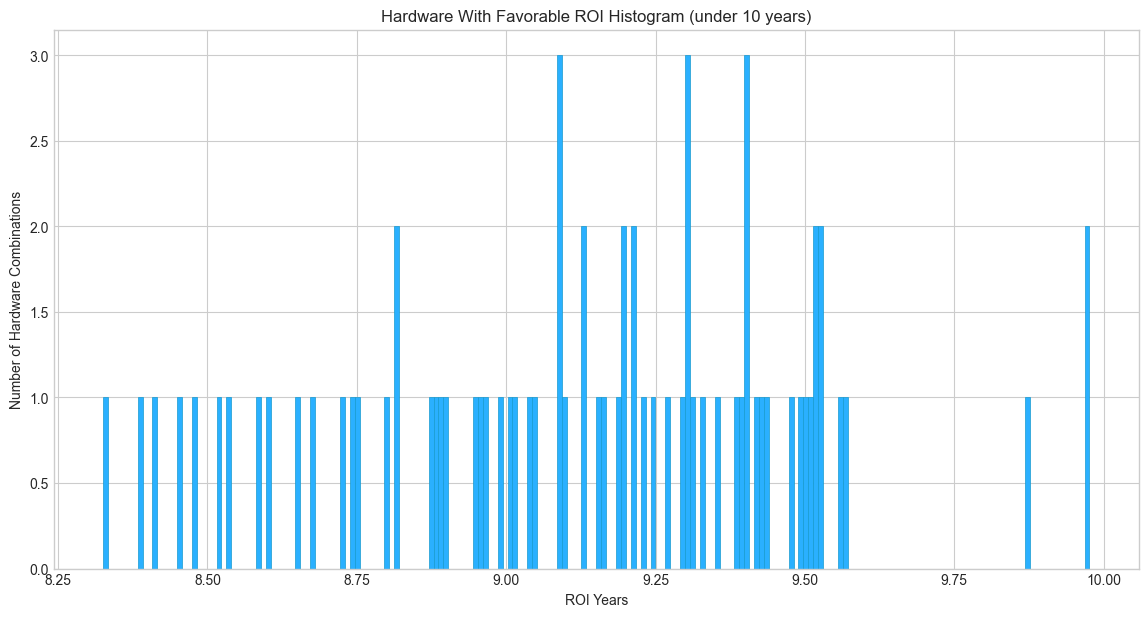

In [39]:

# Make it 14x7 inch
plt.figure(figsize=(14,7)) # Make it 14x7 inch
plt.style.use('seaborn-whitegrid') # nice and clean grid
plt.hist(favROI_products_df['roi'], bins=200, facecolor = '#2ab0ff', edgecolor='#169acf', linewidth=0.5)
plt.title('Hardware With Favorable ROI Histogram (under 10 years)') 
plt.xlabel('ROI Years') 
plt.ylabel('Number of Hardware Combinations') 
plt.show()

<AxesSubplot:title={'center':'Available Hardware w/ Favorable ROIs'}, xlabel='batWh', ylabel='pvW'>

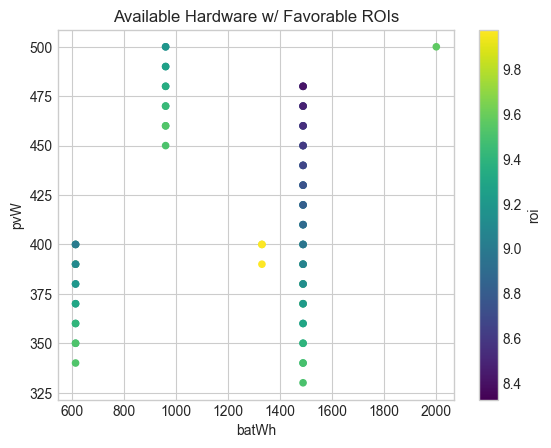

In [40]:
favROI_products_df.plot(kind = 'scatter', x = 'batWh', y = 'pvW', c='roi',colormap='viridis', title='Available Hardware w/ Favorable ROIs')


In [41]:
# income from ROI to EOL 
# iar = income after return


favROI_products_df['iar'] = (favROI_products_df['lifespan'] - favROI_products_df['roi']) * favROI_products_df['annualIncome']

#usable_products_df[usable_products_df['iar'] == max(usable_products_df['iar'])] 


minIar = round(min(favROI_products_df['iar']),2)
print("Minimum IAR: $" + str(minIar) + " ($" + str(minIar/10) + "/yr for 10 years)")
maxIar = round(max(favROI_products_df['iar']),2)
print("Maximum IAR: $" + str(maxIar) + " ($" + str(maxIar/10) + "/yr for 10 years)")

Minimum IAR: $3.77 ($0.377/yr for 10 years)
Maximum IAR: $358.98 ($35.898/yr for 10 years)


<AxesSubplot:title={'center':'Available Hardware w/ Favorable ROIs'}, xlabel='batWh', ylabel='iar'>

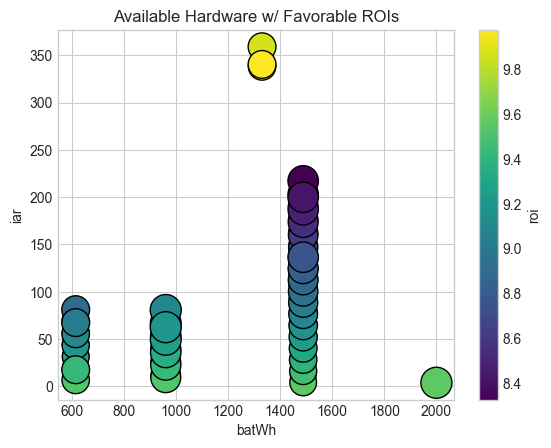

In [42]:
favROI_products_df.plot(kind = 'scatter', x = 'batWh', y = 'iar', c='roi',s='pvW',edgecolor='black',colormap='viridis', title='Available Hardware w/ Favorable ROIs')


In [ ]:
favROI_products_df.plot(kind = 'scatter', x = 'batWh', y = 'pvW', c='roi',s='iar',edgecolor='black',colormap='viridis', title='Available Hardware w/ Favorable ROIs')


In [ ]:
# check if cheapest is best or if the results differ

## Loads

### Typical Appliances

#### Fixed
* Refrigerator

#### Behavior Dependent
Note that baselines are determined by X, so random loads that aren't used at generally the same time each day wouldn't be considered.
* AC
* Fan
* Lamp
* Overhead lights
* Computer
* Electric Stove
* Convection stove

In [ ]:
# Typical refrigerator
# source: https://www.energysage.com/electricity/house-watts/how-many-watts-does-a-refrigerator-use/#:~:text=A%20home%20refrigerator's%20power%20consumption,amps%20and%20about%20120%20volts.
fridgeDutyCycle = .333

fridgeMaxW = 800 * fridgeDutyCycle
fridgeMinW = 300 * fridgeDutyCycle
print('Fridge Watts')
print('Max: ' + str(fridgeMaxW) + 'W (' + str(fridgeMaxW * 24) + ' Wh/day)')
print('Min: ' + str(fridgeMinW) + 'W (' + str(fridgeMinW * 24) + ' Wh/day)')



# Discussion

Operational costs may be able to be met from the DR income after ROI has been reached

Report data:
* inputs
    * network details
* What is the income from the point of ROI to end of life?

In [ ]:
#info for report

reportVars = ['tot representative','tot real', 'biggest','smallest',]
